# DHS Data Compression and Extraction


Load data and necessary libraries 

In [2]:
% matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import IOFunctions as iof
import os 
import pprint as pp
import pandas as pd
import cv2
import pickle
import configparser
import tempfile

Use some of the code we used before to extract PCA compressed versions of the data.

* Load 10% resized dataset
* Examine cumulative distribution of data and determine threshold
* After determining threshold, clear noise
* After clearing noise, normalize data, excluding the background.

In [9]:
#Load the data
pickle_name = 'prelim_dataset.pickle'
with open(pickle_name,"rb") as f:
    save = pickle.load(f)
    training_features = save['features']
    training_labels = save['labels']
print("Shape of features: {}".format(training_features.shape))
print("Shape of labels: {}".format(training_labels.shape))

Shape of features: (124, 300, 300, 8)
Shape of labels: (124, 17)


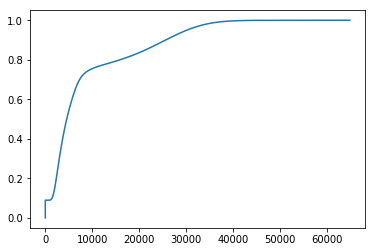

In [4]:
#Use 10% of the (resized) code to estimate the noice reducing threshold
def getCumSum(x):
    x_flat = np.sort(x,axis=None)
    n = len(x_flat)
    perc = [i/n for i in np.arange(1,n+1)]
    return x_flat,perc

x, p = getCumSum(training_features)
plt.plot(x,p)        
        

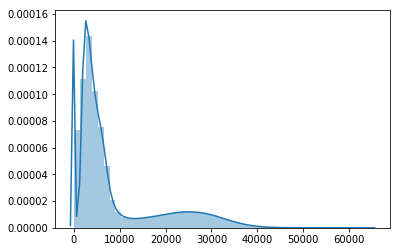

In [5]:
#Standard distribution
sns.distplot(x)

In [10]:
#Now, let's apply these duntions to the entire dataset and plot the distribution again.
#We want to normalize over the entire dataset, so that we may be able to handle duds, or samples with no subject in them.
NOISE_THRESHOLD = 7000
def NormalizeImage(x,average,std):
    return (x-average)/std

def ExtractNormParameters(x):
    mask = x > NOISE_THRESHOLD
    average = np.average(x,weights = mask)
    std = x[mask].std()
    return average,std

def ReduceNoise(x):
    if x < NOISE_THRESHOLD:
        x = NOISE_THRESHOLD
    return x

def CleanData(x):
    ReduceNoise_v = np.vectorize(ReduceNoise)
    average, std = ExtractNormParameters(x)
    for s in range(x.shape[0]):
        for a in  range(x.shape[3]):
            x[s,:,:,a] = ReduceNoise_v(x[s,:,:,a])
            x[s,:,:,a] = NormalizeImage(x[s,:,:,a],average,std)
    return average, std


Reduce noise and normalize before PCA.

The parameters used were an average of20212.10523040469 and std of9261.439914808247


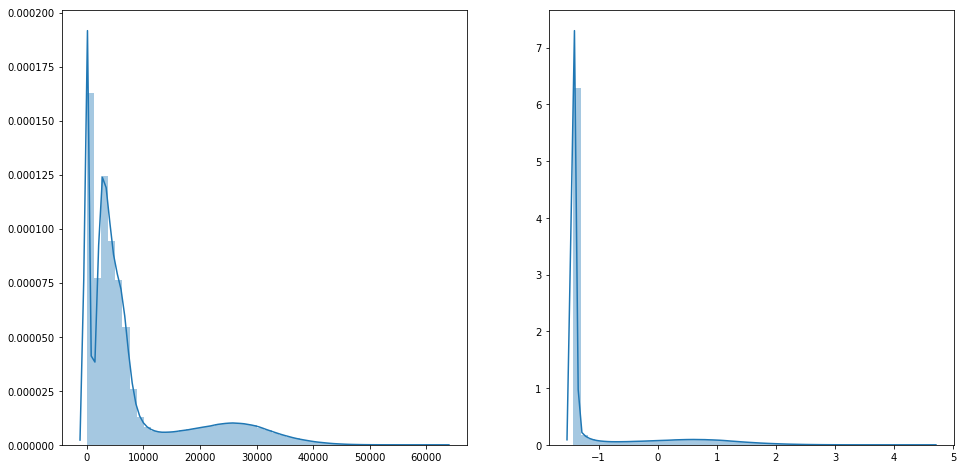

In [11]:
#Clean data, visualizing distributions before and after
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

np.random.seed(seed=0)
#Visualize 10 random samples
samples = np.random.randint(0,training_features.shape[0],10)
sns.distplot(training_features[samples,:,:,:].flatten(),ax=ax)

average, std = CleanData(training_features)
sns.distplot(training_features[samples,:,:,:].flatten(),ax=ax2)

print("The parameters used were an average of {} and std of {}".format(average,std))

Now that we have established a preprocessing scheme for the data, we can apply this scheme iteratively to batches of the data before fitting them using incremental PCA. 

In [ ]:
#First fit PCA

In [ ]:
#Now iterate over data again and extract data set. 

Create train and test sets.

In [9]:
#Divide the data into train, test 
from sklearn.model_selection import train_test_split
training_features_rs = np.reshape(training_features,(training_features.shape[0],
                                             training_features.shape[1]*training_features.shape[2]*training_features.shape[3]))
X_train,X_test,y_train,y_test = train_test_split(training_features_rs,training_labels,random_state=0,train_size=0.80)
del training_features_rs #Prevent memory issues

/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
